In [1]:
%matplotlib notebook
import numpy as np
import operator
import scipy
import math
import scipy.ndimage
import matplotlib.patches
from scipy.spatial import distance
import photutils
from photutils import centroid_com
from scipy import ndimage
import h5py
import matplotlib
import matplotlib.pyplot as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cv2
from scipy.ndimage.morphology import binary_fill_holes
import os, re
import sys
sourcepath = '/Users/niloo/Desktop/SwissFel_2019/data_beamtime/SwissFEL_BERNINA_20181820-master/src'
sys.path.insert(0, sourcepath)
import calibrators
from calibrators import *
from skimage import morphology
import skimage

In [2]:
files = {'r0144':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0144_type1-peaks_with_q.h5',
         'r0145':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0145_type1-peaks_with_q.h5',
         'r0146':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0146_type1-peaks_with_q.h5',
         'r0147':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0147_type1-peaks_with_q.h5',
         'r0151':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0151_type1-peaks_with_q.h5',
         'r0165':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0165_type1-peaks_with_q.h5',
         'r0166':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0166_type1-peaks_with_q.h5',
         'r0167':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0167_type1-peaks_with_q.h5',
         'r0168':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0168_type1-peaks_with_q.h5',
         'r0169':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0169_type1-peaks_with_q.h5',
         'r0170':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0170_type1-peaks_with_q.h5',
         'r0171':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0171_type1-peaks_with_q.h5',
         'r0172':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0172_type1-peaks_with_q.h5',
         'r0173':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0173_type1-peaks_with_q.h5'}

f_tuples = sorted(files.items(), key=operator.itemgetter(1))
runs = sorted(np.array([n[0] for n in f_tuples]))
files_pass = np.array([n[1] for n in sorted(f_tuples)])

In [3]:
def specific_shots(run, shot, path=None):
    '''
    open specific shots in a run and load its keys,
    '''
    if path is None:
        h5path = '/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/%s_type1-peaks_with_q.h5'%run
    else:
        h5path = path+'%s_type1-peaks.h5'%run
    h5file = h5py.File(h5path,'r')
    n_peaks = h5file['shots'][shot]['numberOfPeaks'][()]
    peak_list = []
    center_mass = []
    radius = []
    q_cm = []
    for i,j in enumerate(shot):
        try:
            peak_list.append(h5file['shots'][shot]['peak%d'%i]['diffraction'][:])
            center_mass.append(h5file['shots'][shot]['peak%d'%i]['centerOfMassInPixels'][:])
            radius.append(h5file['shots'][shot]['peak%d'%i]['radiusInPixels'][()])
            q_cm.append(h5file['shots'][shot]['peak%d'%i]['peakCenterOfMassQMagnitude'][:])
        except:
            pass
    h5file.close()
    return  {'peaks': peak_list,
             'center_mass': center_mass,
             'q_cm': q_cm,
             'No_of_peaks': n_peaks,
             'radiusInPixels': radius}

In [109]:
#zx = specific_shots('r0167','LCLS_2011_Mar01_r0167_003110_c62d_cspad')['peaks'][6]
#zx = specific_shots('r0173', 'LCLS_2011_Mar01_r0173_031702_173d0_cspad')['peaks'][5]
zx = specific_shots('r0169', 'LCLS_2011_Mar01_r0169_015125_13b27_cspad')['peaks'][0]
p6 = specific_shots('r0167','LCLS_2011_Mar01_r0167_003110_c62d_cspad')['peaks'][6]

In [113]:
#blur = skimage.filters.gaussian(zx, sigma=1, preserve_range=True)
zx[np.where(zx < 0)] = 0
blur = skimage.filters.gaussian(zx, sigma=1)

In [114]:
# perform adaptive thresholding
#t = skimage.filters.threshold_otsu(np.nan_to_num(np.log(blur), nan=np.nanmin(np.log(blur))))
t = skimage.filters.threshold_otsu(np.nan_to_num(np.log(blur)))
mask = np.nan_to_num(np.log(blur)) > t

<IPython.core.display.Javascript object>


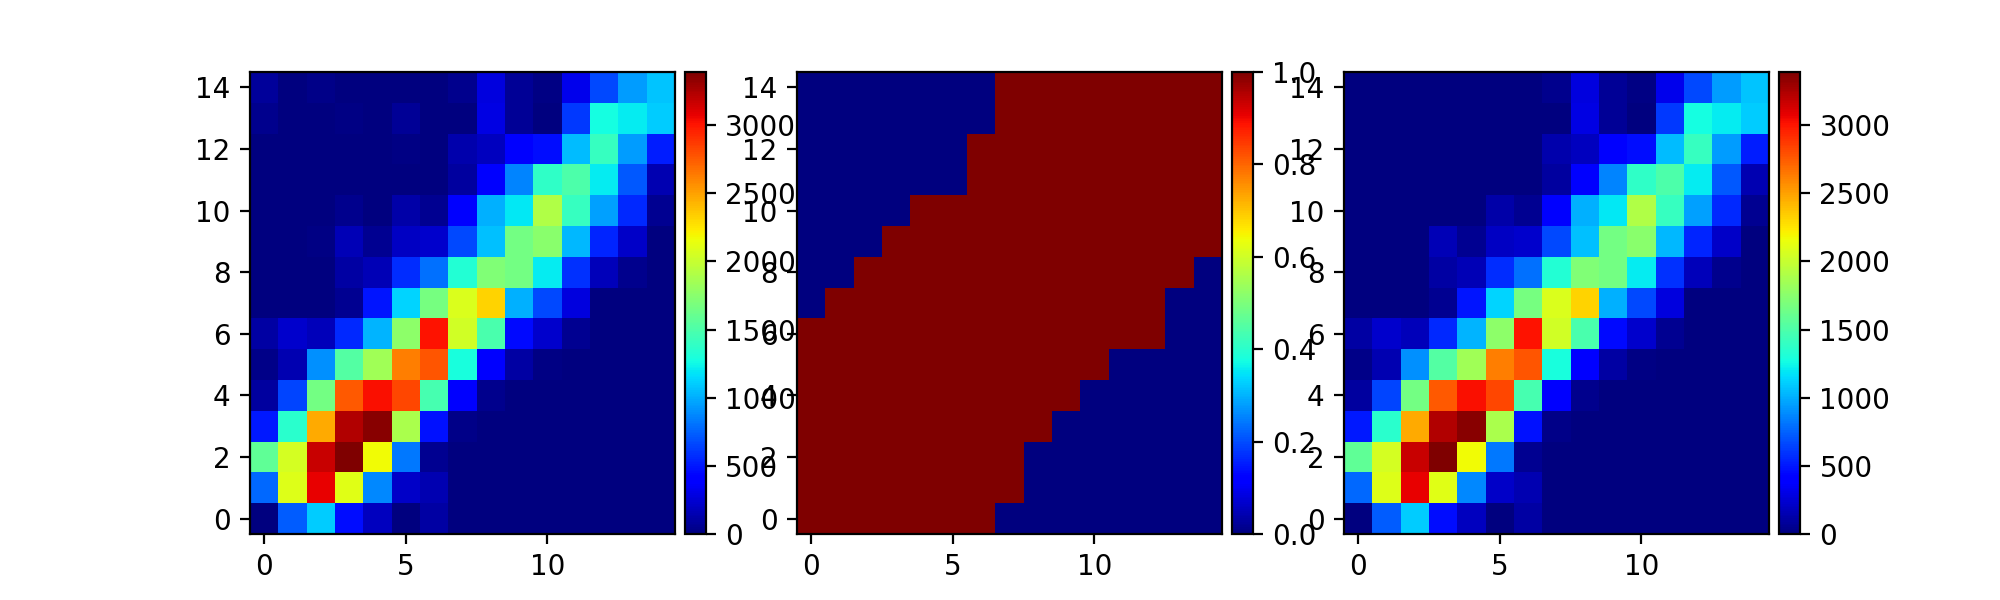

In [117]:
from scipy.ndimage import gaussian_filter
filtered = gaussian_filter(zx, sigma=1, mode='nearest', truncate =10)
#p_sub = filtered - BG_level
#p_mask = p_sub > photon_threshold
fill_holes = binary_fill_holes(mask)
#processed = morphology.remove_small_objects(fill_holes.astype(bool), min_size=5, connectivity=2).astype(int)
labeled_image, number_of_peaks = scipy.ndimage.label(fill_holes.astype(np.float32))
peak_regions = scipy.ndimage.find_objects(labeled_image)
#p = fill_holes[peak_regions[4]]
fig = plt.figure(figsize = [10,3])
ax1 = fig.add_subplot(131)  # left side
ax2 = fig.add_subplot(132)  # right side
ax3 = fig.add_subplot(133)
# use the mask to select the "interesting" part of the image
sel = np.zeros_like(zx)
sel[mask] = zx[mask]
im1 = ax1.imshow(zx,cmap='jet', origin = 'lower', aspect='auto')
im2 = ax2.imshow(mask, cmap='jet', origin = 'lower', aspect='auto')
im3 = ax3.imshow(sel, cmap='jet', origin = 'lower', aspect='auto')

divider1 = make_axes_locatable(ax1)
divider2 = make_axes_locatable(ax2)
divider3 = make_axes_locatable(ax3)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
cax3 = divider3.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')
fig.colorbar(im3, cax=cax3, orientation='vertical')
#plt.clim(vmin=0,vmax=400)
plt.show()

In [42]:
skimage.filters.gaussian?

In [53]:
s = []
for p,i in enumerate(peak_regions2):
    contour,_= cv2.findContours(fill_holes2[i].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for cnt in contour:
        perimeter = cv2.arcLength(cnt, True)
        area = cv2.contourArea(cnt)
        if perimeter != 0:
            sphericity = 4*np.pi*area/(perimeter**2)
            s.append(sphericity)

In [54]:
s

[0.8202139593974218, 0.39074575324193467, 0.8202139593974218]

<IPython.core.display.Javascript object>


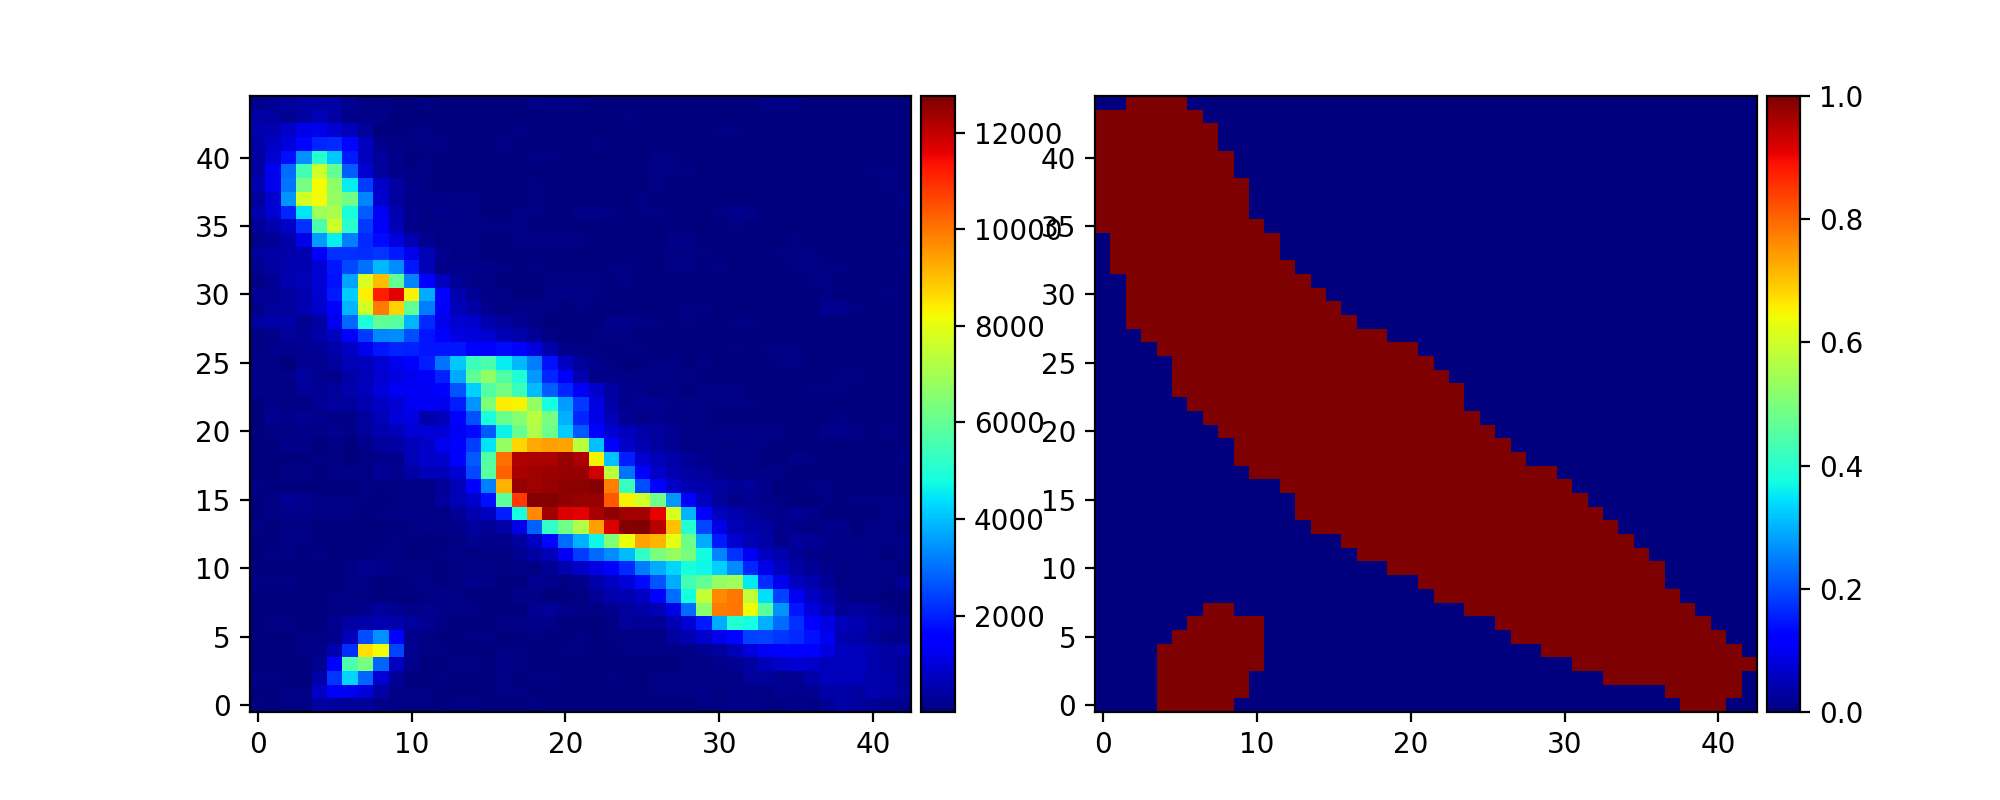

In [51]:
xc = specific_shots('r0167', 'LCLS_2011_Mar01_r0167_004242_94d7_cspad')['peaks'][6]

blur2 = skimage.filters.gaussian(xc, sigma=1)

# perform adaptive thresholding
t2 = skimage.filters.threshold_otsu(np.nan_to_num(np.log(blur2)))
mask2 = np.nan_to_num(np.log(blur2)) > t2
fill_holes2 = binary_fill_holes(mask2)
#processed = morphology.remove_small_objects(fill_holes.astype(bool), min_size=5, connectivity=2).astype(int)
labeled_image2, number_of_peaks2 = scipy.ndimage.label(fill_holes2.astype(np.float32))
peak_regions2 = scipy.ndimage.find_objects(labeled_image2)
#p = fill_holes[peak_regions[4]]
fig = plt.figure(figsize = [10,4])
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side

im1 = ax1.imshow(xc,cmap='jet', origin = 'lower', aspect='auto')
im2 = ax2.imshow(mask2, cmap='jet', origin = 'lower', aspect='auto')
divider1 = make_axes_locatable(ax1)
divider2 = make_axes_locatable(ax2)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')
#plt.clim(vmin=0,vmax=400)
plt.show()

<IPython.core.display.Javascript object>


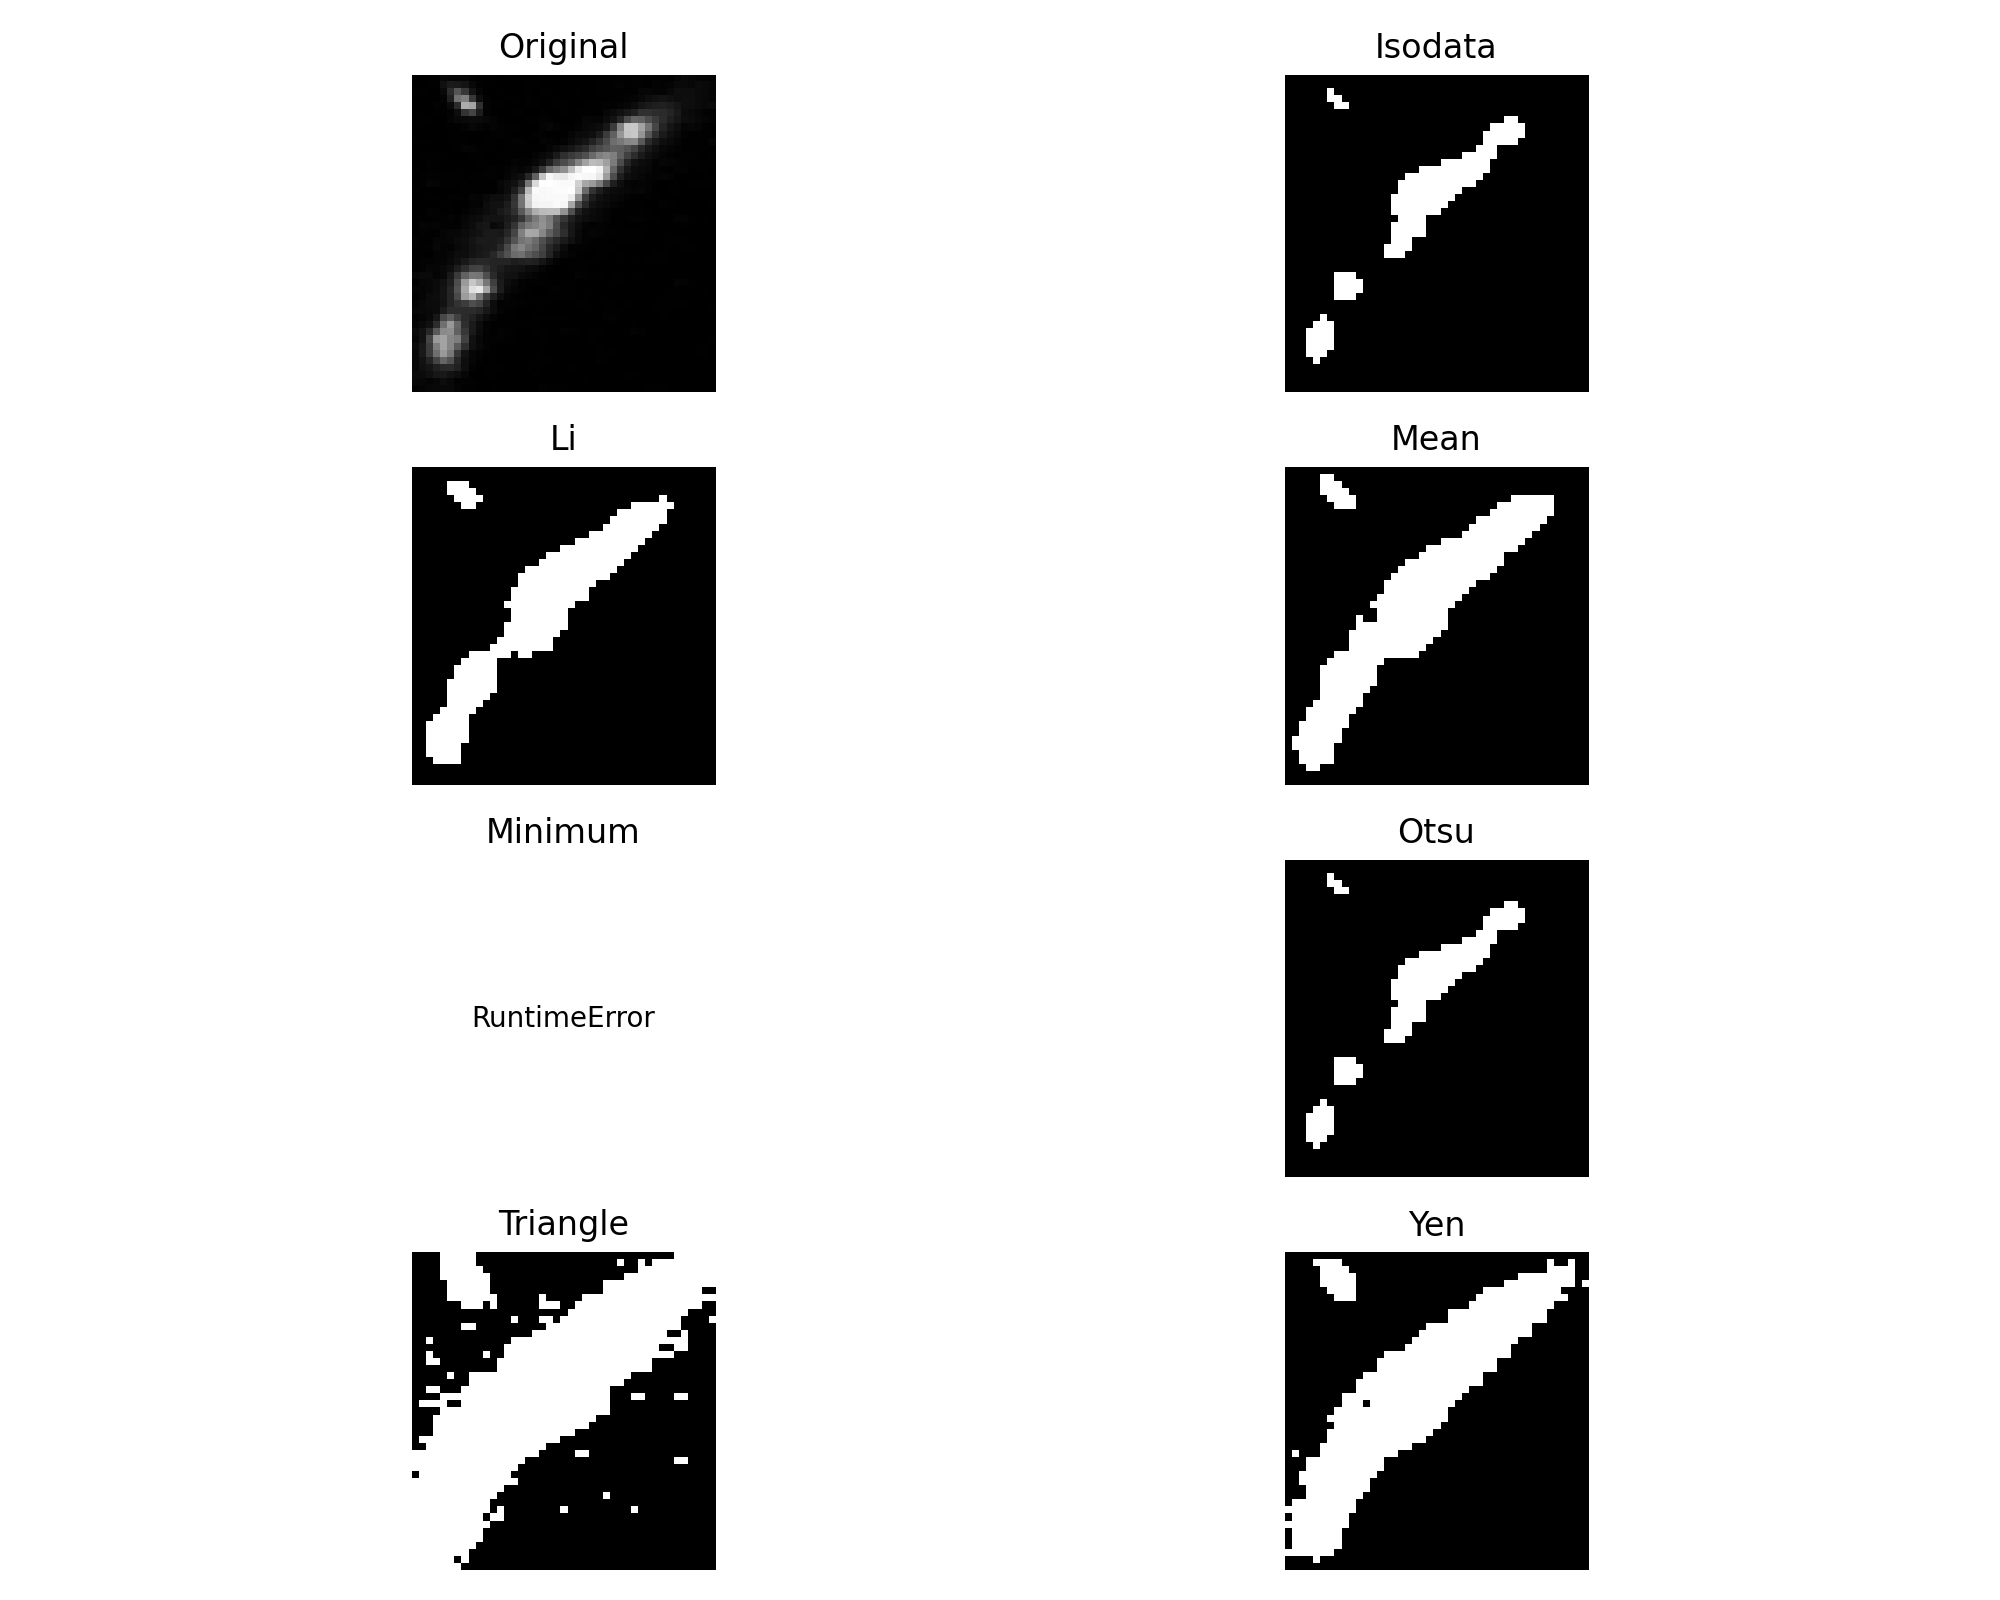

In [52]:
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(xc, figsize=(10, 8), verbose=False)
plt.show()


<IPython.core.display.Javascript object>


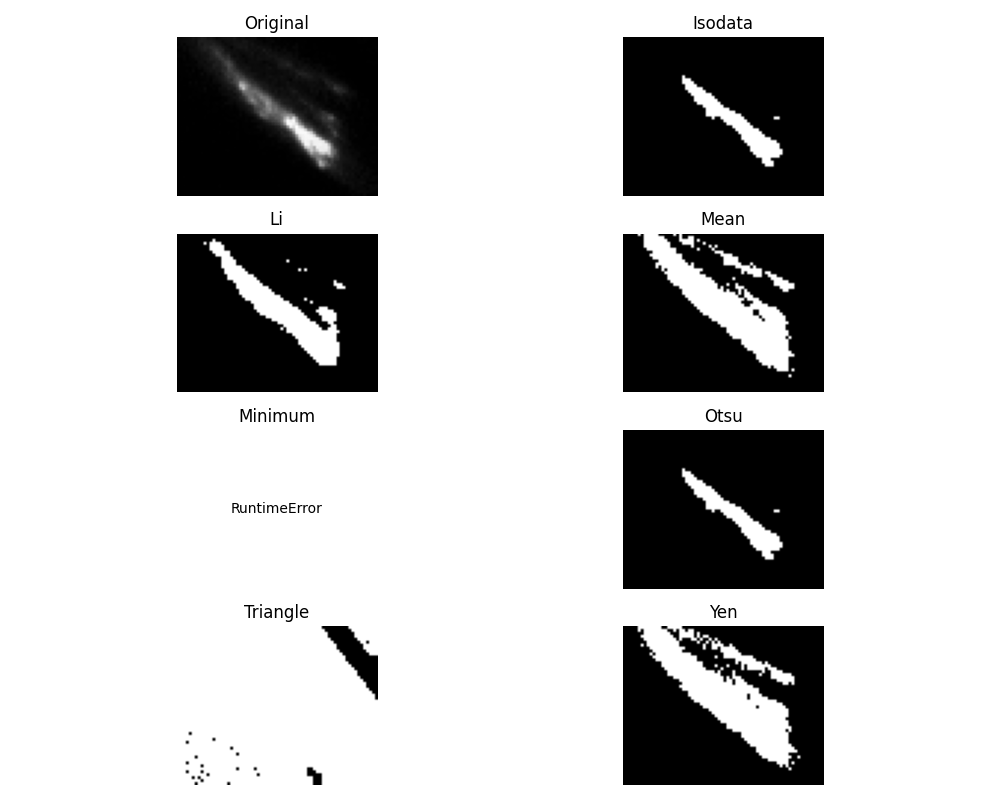

In [31]:
from skimage.filters import try_all_threshold

p_test = specific_shots('r0173','LCLS_2011_Mar01_r0173_031028_1496d_cspad')['peaks'][0]
blur = skimage.filters.gaussian(p_test, sigma=1)
t = skimage.filters.threshold_otsu(blur)
mask = blur > t
fill_holes = binary_fill_holes(mask)

fig, ax = try_all_threshold(p_test, figsize=(10, 8), verbose=False)
plt.show()
